## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import auc, roc_auc_score, roc_curve


In [66]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [67]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [68]:
categorical_features = df.select_dtypes(include='object').columns
print(categorical_features)
numerical_features = df.drop(columns=['converted'], axis = 1).select_dtypes(exclude='object').columns
print(numerical_features)

Index(['lead_source', 'industry', 'employment_status', 'location'], dtype='object')
Index(['number_of_courses_viewed', 'annual_income', 'interaction_count',
       'lead_score'],
      dtype='object')


In [69]:
df[categorical_features] = df[categorical_features].fillna("NA")
df[numerical_features]= df[numerical_features].fillna(0.0)

In [70]:
for c in df[categorical_features].columns:
    print(df[c].nunique())

6
8
5
8


In [71]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [72]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- [ ] `lead_score`
- [X] `number_of_courses_viewed` :check
- [ ] `interaction_count`
- [ ] `annual_income`


In [73]:

scores = {}
for c in df_train[numerical_features].columns:
    score = roc_auc_score(y_train,df_train[c])
    scores[c]=score

print(scores)

{'number_of_courses_viewed': 0.7635680590007088, 'annual_income': 0.5519578313253012, 'interaction_count': 0.738270176293409, 'lead_score': 0.6144993577250176}


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92


In [74]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [75]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

model.fit(X_train,y_train)

y_pred = model.predict(X_val)

In [76]:
score = roc_auc_score(y_val,y_pred)
print(score)

0.647564950627936


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745


In [77]:
df_scores = []

y_pred = model.predict_proba(X_val)[:, 1]

for t in np.linspace(0,1,101):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    df_scores.append([t,p,r])

df_scores = pd.DataFrame(df_scores, columns=['Thresholds','Precision','Recall'])
df_scores



C:\Users\marcio_constancio\AppData\Local\Temp\ipykernel_3248\1603129241.py:17: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


,Thresholds,Precision,Recall
0,0.00,0.583618,1.000000
1,0.01,0.583618,1.000000
2,0.02,0.583618,1.000000
3,0.03,0.583618,1.000000
4,0.04,0.583618,1.000000
...,...,...,...
96,0.96,1.000000,0.017544
97,0.97,1.000000,0.005848
98,0.98,NaN,0.000000
99,0.99,NaN,0.000000


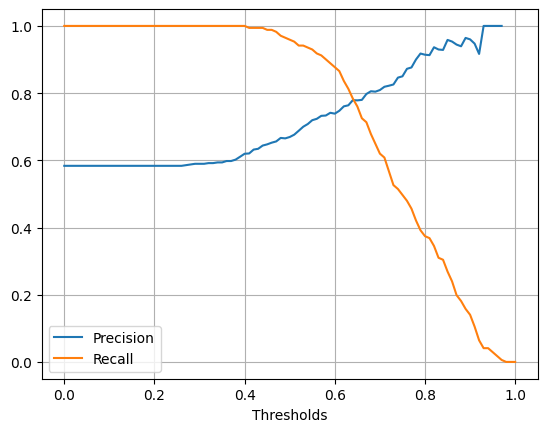

In [78]:
sns.lineplot(data=df_scores, x = 'Thresholds', y = 'Precision', label = 'Precision')
sns.lineplot(data=df_scores, x = 'Thresholds', y = 'Recall', label = 'Recall')
plt.ylabel("")
plt.legend()
plt.grid(True)
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [79]:
df_scores["F1"] = 2*df_scores['Precision']*df_scores['Recall']/(df_scores['Precision'] + df_scores['Recall'])
print(df_scores['F1'].max())

0.8124999999999999


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one